# START OF DEBUGGING CODE

---

# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
8.832865323998703
GPU (s):
0.7966653179992136
GPU speedup over CPU: 11x


In [3]:
tf.__version__

'1.7.0'

In [4]:
!pip list | grep -ib keras

Keras                             2.1.6      


---

# END OF DEBUGGING CODE

---

# Generative Adversarial Networks in Keras 2

In [6]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

In [30]:
tqdm.monitor_interval = 0

## The original GAN!

See [this paper](https://arxiv.org/abs/1406.2661) for details of the approach we'll try first for our first GAN. We'll see if we can generate hand-drawn numbers based on MNIST, so let's load that dataset first.

We'll be refering to the discriminator as 'D' and the generator as 'G'.

In [7]:
from keras.datasets import mnist

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [9]:
X_train.shape

(60000, 28, 28)

In [10]:
n = len(X_train)

In [11]:
X_train = X_train.reshape(n, -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [12]:
X_train /= 255.
X_test /= 255.

## Train

This is just a helper to plot a bunch of generated images.

In [13]:
def plot_gen(G, n_ex=16):
    plot_multi(G.predict(noise(n_ex)).reshape(n_ex, 28,28), cmap='gray')

Create some random data for the generator.

In [14]:
def noise(bs):
    return np.random.rand(bs,100)

Create a batch of some real and some generated data, with appropriate labels, for the discriminator.

In [15]:
def data_D(sz, G):
    real_img = X_train[np.random.randint(0,n,size=sz)]
    X = np.concatenate((real_img, G.predict(noise(sz))))
    return X, [0]*sz + [1]*sz

In [25]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

Train a few epochs, and return the losses for D and G. In each epoch we:

1. Train D on one batch from data_D()
2. Train G to create images that the discriminator predicts as real.

In [26]:
def train(D, G, m, nb_epoch=5000, bs=128):
    dl, gl=[], []
    for e in tqdm(range(nb_epoch)):
        X, y = data_D(bs//2, G)
        dl.append(D.train_on_batch(X, y))
        make_trainable(D, False)
        gl.append(m.train_on_batch(noise(bs), np.zeros([bs])))
        make_trainable(D, True)
    return dl, gl

## MLP GAN

We'll keep things simple by making D & G plain ole' MLPs.

In [27]:
MLP_G = Sequential([
    Dense(200, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(784, activation='sigmoid'),
])

In [28]:
MLP_D = Sequential([
    Dense(300, input_shape=(784,), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")

In [29]:
MLP_m = Sequential([MLP_G,MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [21]:
dl, gl = train(MLP_D, MLP_G, MLP_m, 8000)

  0%|          | 0/8000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  6%|▌         | 471/8000 [00:09<02:38, 47.43it/s]/usr/local/lib/python3.6/dist-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 8000/8000 [02:26<00:00, 54.45it/s]


During training, received warning that says `/path/to/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set model.trainable without calling model.compile after ?` Refer to GitHub [issue](https://github.com/keras-team/keras/issues/8585).

tqdm is throwing a warning that says `TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)`.

The workaround is disable the monitor thread by doing:

`tqdm.monitor_interval = 0`

before the rest of your code.

In [31]:
dl, gl = train(MLP_D, MLP_G, MLP_m, 8000)

  0%|          | 0/8000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 8000/8000 [02:27<00:00, 54.30it/s]


The loss plots for most GANs are nearly impossible to interpret - which is one of the things that make them hard to train.

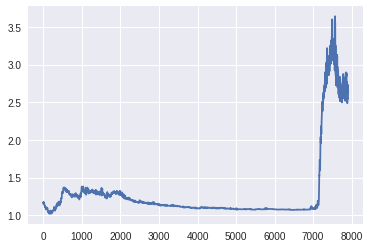

In [32]:
plt.plot(dl[100:])

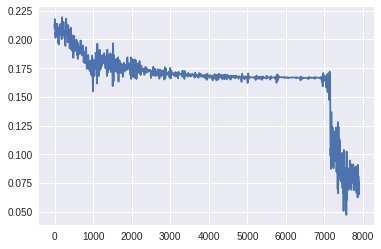

In [33]:
plt.plot(gl[100:])

This is what's known in the literature as "mode collapse".

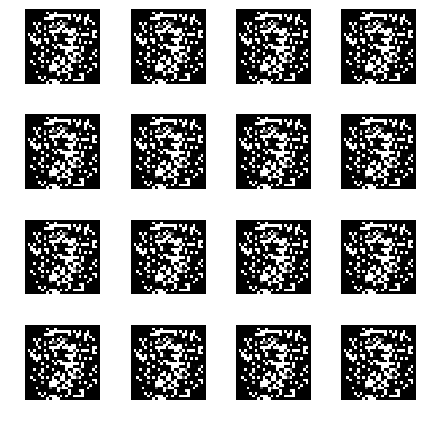

In [35]:
plot_gen(MLP_G)

OK, so that didn't work. Can we do better?...

## DCGAN

There's lots of ideas out there to make GANs train better, since they are notoriously painful to get working. The [paper introducing DCGANs](https://arxiv.org/abs/1511.06434) is the main basis for our next section. And see https://github.com/soumith/ganhacks for many tips!

Because we're using a CNN from now on, we'll reshape our digits into proper images.

In [37]:
X_train = X_train.reshape(n, 28, 28, 1)

In [40]:
assert(X_train.shape == (n, 28, 28, 1))

In [41]:
X_test = X_test.reshape(len(X_test), 28, 28, 1)

In [42]:
assert(X_test.shape == (len(X_test), 28, 28, 1))

Our generator uses a number of upsampling steps as suggested in the above papers. We use nearest neighbor upsampling rather than fractionally strided convolutions, as discussed in our style transfer notebook.

### Start of Migrations to Keras 2

---

In [44]:
act = keras.layers.advanced_activations.LeakyReLU()

Received `UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.`

https://stackoverflow.com/questions/34717241/how-to-use-advanced-activation-layers-in-keras

Received "UserWarning: Update your `Conv2D` call to the Keras 2 API.".

Fixes:
- https://github.com/keras-team/keras/issues/9259
- https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes#convolutional-layers

Received "UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model."

Received "TypeError: The `mode` argument of `BatchNormalization` no longer exists. `mode=1` and `mode=2` are no longer supported."

In [71]:
# My own Keras layer for BatchNormalization with mode 2 supports.
# What is mode 2? feature-wise normalization. https://faroit.github.io/keras-docs/1.2.2/layers/normalization/
# Keras 2.0 removed batch norm mode 2. See 2.0 release notes: https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes#batchnormalization
# https://github.com/keras-team/keras/issues/5892#issuecomment-332534932
# Asking for migration docs for this change: https://github.com/keras-team/keras/issues/3756
import normalization_mode2; importlib.reload(normalization_mode2)
from normalization_mode2 import *

### End of Migrations to Keras 2

---

In [73]:
CNN_G = Sequential([
    Dense(512*7*7, input_dim=100),
    act, # Changed for Keras 2 API
    # BatchNormalization(mode=2),
    BatchNormalizationMode2(mode=2), # Changed for Keras 2 API
    Reshape((7, 7, 512)),
    UpSampling2D(),
    Conv2D(64, (3, 3), padding='same'), # Changed for Keras 2 API
    act, # Changed for Keras 2 API
    # BatchNormalization(mode=2),
    BatchNormalizationMode2(mode=2), # Changed for Keras 2 API
    UpSampling2D(),
    Conv2D(32, (3, 3), padding='same'), # Changed for Keras 2 API
    act, # Changed for Keras 2 API
    #BatchNormalization(mode=2),
    BatchNormalizationMode2(mode=2), # Changed for Keras 2 API
    Conv2D(1, (1, 1), padding='same', activation='sigmoid') # Changed for Keras 2 API
])

The discriminator uses a few downsampling steps through strided convolutions.

In [76]:
CNN_D = Sequential([
    Conv2D(256, (5, 5), padding='same', input_shape=(28, 28, 1), strides=(2, 2)), # Changed for Keras 2 API
    act, # Changed for Keras 2 API
    Conv2D(512, (5, 5), padding='same', strides=(2, 2)), # Changed for Keras 2 API
    act, # Changed for Keras 2 API
    Flatten(),
    Dense(256),
    act, # Changed for Keras 2 API
    Dense(1, activation='sigmoid')
])
CNN_D.compile(Adam(1e-3), 'binary_crossentropy')

We train D a "little bit" so it can at least tell a real image from random noise.

In [78]:
sz = n // 200
x1 = np.concatenate([np.random.permutation(X_train)[:sz], CNN_G.predict(noise(sz))])
CNN_D.fit(x1, [0]*sz + [1]*sz, batch_size=128, epochs=1, verbose=2)

Epoch 1/1
 - 1s - loss: 0.0283


In [79]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-3), 'binary_crossentropy')

In [81]:
K.set_value(CNN_D.optimizer.lr, 1e-3)
K.set_value(CNN_m.optimizer.lr, 1e-3)

Now we can train D & G iteratively.

In [82]:
dl, gl = train(CNN_D, CNN_G, CNN_m, 2500)

  0%|          | 0/2500 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 2500/2500 [12:23<00:00,  3.36it/s]


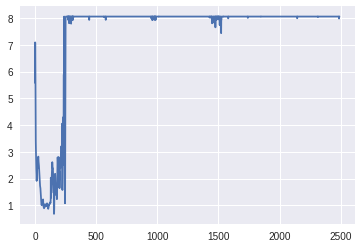

In [83]:
plt.plot(dl[10:])

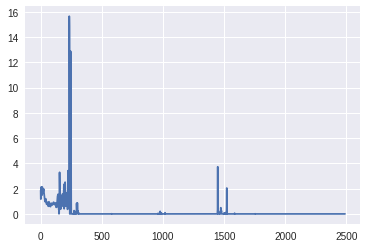

In [84]:
plt.plot(gl[10:])

Better than our first effort, but still a lot to be desired...

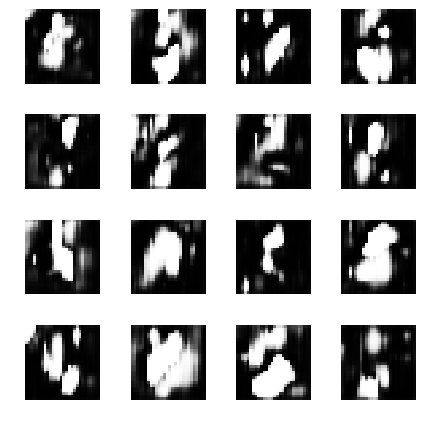

In [85]:
plot_gen(CNN_G)

### End